In [1]:
import os
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [2]:
transform=transforms.Compose([
    transforms.RandomRotation(10),      # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # reverse 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
dataset=datasets.ImageFolder(root=("../dataset"),transform=transform)

In [6]:
class_names=dataset.classes
print(class_names)
print(len(class_names))

['Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1', 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+', 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2', 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1', 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+', 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2', 'NORMAL T1', 'NORMAL T2', 'Neurocitoma (Central - Intraventricular, Extraventricular) T1', 'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+', 'Neurocitoma (Central - Intraventricular, Extraventricular) T2', 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1', 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+', 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2', 'Schwannoma (Acustico, Vestibular - Trigeminal) T1', 'Schwannoma (Acustico, Vestibu

In [7]:
torch.manual_seed(10)
test_size = len(dataset)//5
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(3559, 889)

In [8]:
train_loader=DataLoader(train_ds,batch_size=16,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=16)

In [9]:
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=8)

Label: [ 5  4  6 14  0  1 10  9  0 11  3  4  3  5  7 16]
Class: Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+ NORMAL T1 Schwannoma (Acustico, Vestibular - Trigeminal) T1 Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1 Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+ Neurocitoma (Central - Intraventricular, Extraventricular) T2 Neurocitoma (Central - Intraventricular, Extraventricular) T1C+ Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1 Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+ Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1 Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2 NORMAL T2 Schwannoma (Acustico,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


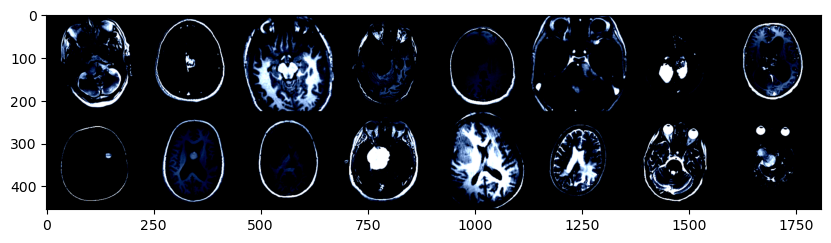

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [11]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

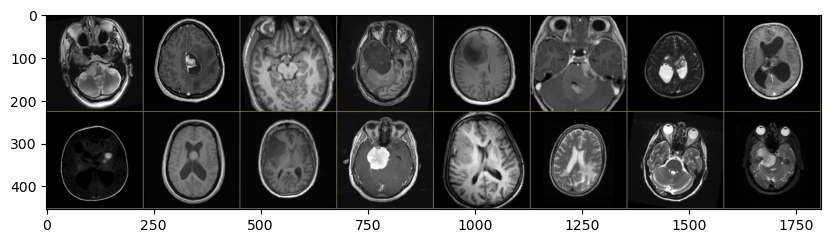

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(16*54*54,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,len(class_names))

    def forward(self,X):
        #print(X.shape)#torch.Size([10,3,224,224])
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)
        X=F.log_softmax(X,dim=1)
        #print(X.shape)#torch.Size([10,80])
        return X

In [14]:
mycnn=MyCNN()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(mycnn.parameters(),lr=0.001)

In [15]:
mycnn

MyCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=17, bias=True)
)

In [16]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(mycnn)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    1680
      20
     340
      17
________
 5612109


In [17]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]


for i in range(30):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred=mycnn(X_train)
        loss=criterion(y_pred,y_train)
        #true predictions
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200==0:
            print(f"epoch: {i} loss: {loss.item} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)


    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=mycnn(X_test)
            loss=criterion(y_val,y_test)

            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

        loss=loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 0 loss: <built-in method item of Tensor object at 0x12e8f2930> batch: 200 accuracy:  40.050%
epoch: 1 loss: <built-in method item of Tensor object at 0x12e915580> batch: 200 accuracy:  80.800%
epoch: 2 loss: <built-in method item of Tensor object at 0x12e9621b0> batch: 200 accuracy: 105.150%
epoch: 3 loss: <built-in method item of Tensor object at 0x12e962160> batch: 200 accuracy: 121.000%
epoch: 4 loss: <built-in method item of Tensor object at 0x12e9d2340> batch: 200 accuracy: 129.000%
epoch: 5 loss: <built-in method item of Tensor object at 0x12e9627a0> batch: 200 accuracy: 136.550%
epoch: 6 loss: <built-in method item of Tensor object at 0x12e961e90> batch: 200 accuracy: 141.200%
epoch: 7 loss: <built-in method item of Tensor object at 0x12e9159e0> batch: 200 accuracy: 141.700%
epoch: 8 loss: <built-in method item of Tensor object at 0x12e9d2d90> batch: 200 accuracy: 146.500%
epoch: 9 loss: <built-in method item of Tensor object at 0x12d5caa20> batch: 200 accuracy: 148.600%


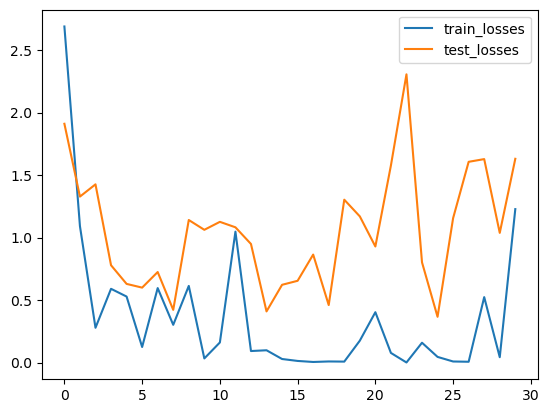

In [18]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()

In [19]:
alex= models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/maron/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:14<00:00, 16.7MB/s] 


In [20]:
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
for param in alex.parameters():
    param.requires_grad=False

In [22]:
torch.manual_seed(42)

alex.classifier=nn.Sequential(nn.Linear(9216,1024),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(1024,80),
                              nn.LogSoftmax(dim=1))
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [23]:
count_parameters(alex)

 9437184
    1024
   81920
      80
________
 9520208


In [24]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alex.classifier.parameters(),lr=0.001)

In [26]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
trn_correct=[]
tst_correct=[]

for i in range(30):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1

        y_pred=alex(X_train)
        loss=criterion(y_pred,y_train)
        #Update parameters
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1

            y_val=alex(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

    loss=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  200 [  2000/8000]  loss: 1.03339827  accuracy:  78.850%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.75411260  accuracy: 106.750%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.41840035  accuracy: 114.600%
epoch:  3  batch:  200 [  2000/8000]  loss: 1.18504715  accuracy: 118.500%
epoch:  4  batch:  200 [  2000/8000]  loss: 0.31757343  accuracy: 120.150%
epoch:  5  batch:  200 [  2000/8000]  loss: 0.49862820  accuracy: 123.250%
epoch:  6  batch:  200 [  2000/8000]  loss: 1.02068365  accuracy: 125.550%
epoch:  7  batch:  200 [  2000/8000]  loss: 0.33239320  accuracy: 127.350%
epoch:  8  batch:  200 [  2000/8000]  loss: 0.49911410  accuracy: 128.350%
epoch:  9  batch:  200 [  2000/8000]  loss: 0.67499804  accuracy: 130.850%
epoch: 10  batch:  200 [  2000/8000]  loss: 0.40397227  accuracy: 132.500%
epoch: 11  batch:  200 [  2000/8000]  loss: 0.46217620  accuracy: 132.450%
epoch: 12  batch:  200 [  2000/8000]  loss: 0.38896158  accuracy: 133.900%
epoch: 13  batch:  200 [ 

In [27]:
device = torch.device("cpu")

In [28]:
mycnn.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = mycnn(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

[0, 5, 4, 4, 10]


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                                                                                       precision    recall  f1-score   support

  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1     0.9000    0.9000    0.9000       100
Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+     0.8941    0.7917    0.8398        96
  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2     0.8169    0.7632    0.7891        76
                     Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1     0.7342    0.8056    0.7682        72
                   Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+     0.8492    0.9145    0.8807       117
                     Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2     0.7703    0.8636    0.8143        66
                                                                            NORMAL T1     0.9344    0.8382    

In [30]:
alex.eval()
ay_true=[]
ay_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = alex(test_images).argmax(dim=1)
        for i in range(len(pred)):
            ay_true.append(test_labels[i].item())
            ay_pred.append(pred[i].item())
print(ay_pred[0:5])

[0, 2, 3, 4, 10]


In [31]:
from sklearn.metrics import classification_report
print(classification_report(ay_true,ay_pred,target_names=class_names,digits=4))

                                                                                       precision    recall  f1-score   support

  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1     0.8857    0.9300    0.9073       100
Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+     0.9667    0.9062    0.9355        96
  Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2     0.8000    0.6842    0.7376        76
                     Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1     0.7875    0.8750    0.8289        72
                   Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+     0.8880    0.9487    0.9174       117
                     Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2     0.6988    0.8788    0.7785        66
                                                                            NORMAL T1     1.0000    0.8529    